# Analysis of Policy and Value Heads

In [3]:
import os
os.chdir('../src')
import numpy as np
import matplotlib.pyplot as plt
import torch
from engine import *
from dataset import board_to_planes
from network import UTTTNet
from tree import Root
from net_player import NetTree

In [4]:
def load_model(name):
    m = UTTTNet()
    m.load_state_dict(torch.load(f'../models/{name}.pt', map_location='cpu'))
    return m.eval()

In [6]:
def policy_head(m, board):
    with torch.no_grad():
        p, v = m(board_to_planes(board))
        print(f'Value: {v.data.item()}')
    return p[0].exp().numpy()

In [61]:
def value_head(m, board):
    v = np.full((9,9), np.nan)
    for i,j in np.ndindex(9,9):
        if not board.legal_moves[i][j]:
            continue
        b = board.copy()
        b.move(i, j)
        with torch.no_grad():
            _, value = m(board_to_planes(b))
        v[i, j] = value
    v = torch.tensor(v).view(3, 3, 3, 3)
    v = torch.cat(v.chunk(3, dim=0), dim=2)
    v = torch.cat(v.chunk(3, dim=1), dim=3)
    return v.squeeze().numpy()

In [69]:
def plot_heads(p, v):
    plt.figure(figsize=(11, 4))
    plt.subplot(121)
    plt.imshow(100*p, vmin=0)
    plt.colorbar()
    plt.title('Policy Head (%)')
    
    plt.subplot(122)
    vmax = 100*np.nanmax(np.abs(v))
    cm = plt.cm.RdBu
    cm.set_bad('gray')
    plt.imshow(100*v, vmin=-vmax, vmax=vmax, cmap=cm)
    plt.colorbar()
    plt.title('Value Head (centi)')
    
    plt.show()

In [39]:
b = BigBoard(bits=[
    hash((1,0,0,0,0,0,0,2,2)),
    hash((0,2,2,0,0,1,1,0,0)),
    hash((0,0,2,1,0,1,1,0,0)),
    hash((0,0,0,2,0,0,1,1,1)),
    hash((0,0,2,0,2,0,2,0,1)),
    hash((0,2,0,2,1,0,0,2,0)),
    hash((0,0,1,0,0,1,2,2,2)),
    hash((0,1,0,2,1,0,0,1,0)),
    hash((1,1,1,0,0,2,0,0,2))
], mover=1, sectors=(2,))
b.draw()

     X │   │   ┃   │ O │ O ┃   │   │ O 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │   ┃   │   │ X ┃ X │   │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │ O │ O ┃ X │   │   ┃ X │   │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │   ┃   │   │ O ┃   │ O │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     O │   │   ┃   │ O │   ┃ O │ X │   
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     X │ X │ X ┃ O │   │ X ┃   │ O │   
    ━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━
       │   │ X ┃   │ X │   ┃ X │ X │ X 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
       │   │ X ┃ O │ X │   ┃   │   │ O 
    ───┼───┼───╋───┼───┼───╋───┼───┼───
     O │ O │ O ┃   │ X │   ┃   │   │ O         
Mover: O, sector: (2,)
       │   │   
    ───┼───┼───
     X │ O │   
    ───┼───┼───
     O │ X │ X     


* 2,1 is win for O in 2
* 2,0 is win for O in 3
* Other moves, X plays 2,0 to win the sector and guarantee at least a draw

### 1000 games

In [185]:
m = load_model('newplane_from00000_100_1000bs2048lr0.1d0.001e3')

Value: -0.009546143934130669


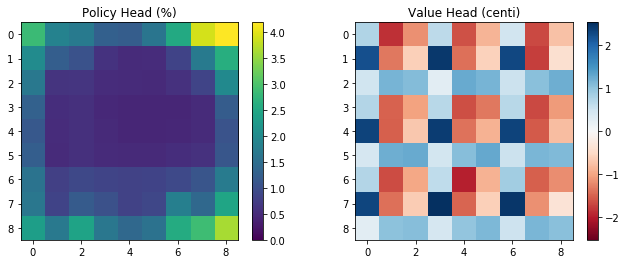

In [186]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.1438795030117035


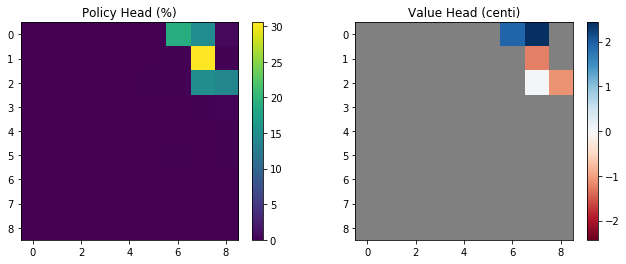

In [187]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

### 1500 games

In [188]:
m = load_model('from00000_150_1500bs2048lr0.1d0.001e3')

Value: 0.0068755438551306725


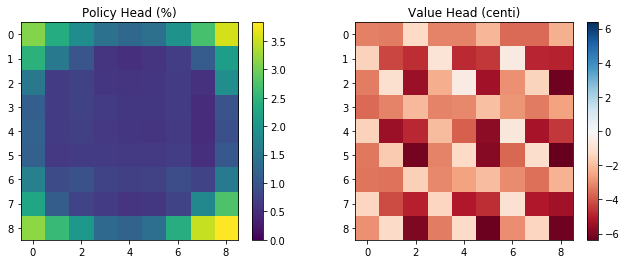

In [189]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: 0.13355468213558197


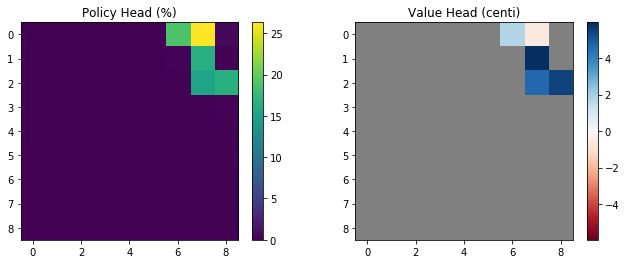

In [190]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

### 2000 games
* Value head strongly prefers center point, enough to dominate puct
* Value head finds the right moves in test position 

In [20]:
m = load_model('scr_dl_200_2000bs2048lr0.1d0.001e3')

Value: 0.09987792372703552


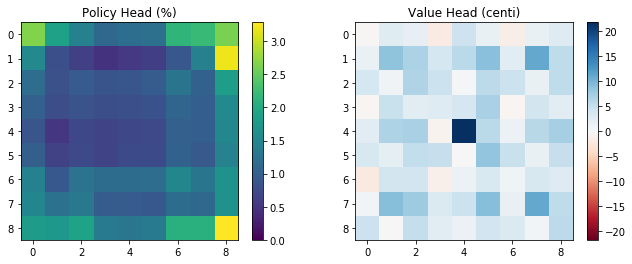

In [36]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.014521576464176178


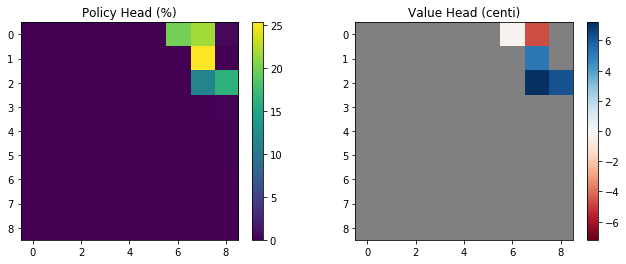

In [70]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

In [41]:
t = NetTree(b, Root(), model=m, noise=False)

In [179]:
for _ in range(490): t.explore()

In [184]:
puct = (t.sign*t.Q + 2.0*t.P*np.sqrt(t.N.sum()))/t.N
print(t.N)
print(t.Q_over_N())
print(puct)
print(t.terminal)
print(t.N.sum())
print(t.v)

[312 121  30  13  19]
[-0.30173505 -1.          0.0171367   0.04579789  0.03273822]
[0.33030287 1.08007939 0.35801147 0.3448362  0.35071704]
[False  True False False False]
495
-1.0


### 2500 games
* Value head continues to prefer center point (see selfplay %X-O)
* Value head more accurately evaluates test position.
* Policy head finds the correct move for test position.

In [7]:
m = load_model('250_2500bs2048lr0.1d0.001e4')

Value: 0.038062579929828644


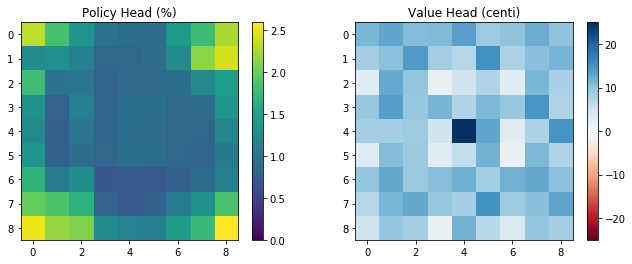

In [8]:
a = BigBoard()
p = policy_head(m, a)
v = value_head(m, a)
plot_heads(p, v)

Value: -0.2829713523387909


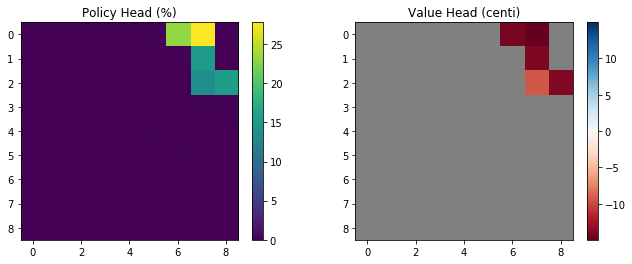

In [9]:
p = policy_head(m, b)
v = value_head(m, b)
plot_heads(p, v)

In [10]:
t = NetTree(b, Root(), model=m, noise=False)

In [33]:
for _ in range(110): t.explore()

In [34]:
puct = (t.sign*t.Q + 2.0*t.P*np.sqrt(t.N.sum()))/t.N
print(t.N)
print(t.Q_over_N())
print(puct)
print(t.terminal)
print(t.N.sum())
print(t.v)

[44 48  8  7  8]
[-0.49793009 -1.         -0.16384773 -0.13208976 -0.165952  ]
[0.61137711 1.12408392 0.57561529 0.55422102 0.58435613]
[False  True False False False]
115
-1.0
